<html>
<h1 style="text-align: center;">Peer-to-Peer</h1>
<h5 style="text-align: center;">Group 7: Adrien Buche, Taku Kaneda, Bruno Losseau, Nadine Uwera</h5>
<br />
</html>


# Contents
0. Introduction
1. Construction of mutitree
2. Primal-Dual Algorithm
   * Problem formulation
   * Smallest price tree problem
3. Numerical result
   * Full mesh graph
   * General graph
4. Concept of Free Riders
5. Conclusion  
 
6. References

## 1. Introduction

The lecture we presented on "Skype and BitTorrent: Peer-to-Peer file sharing system" was mostly about solving the **P2P capacity problem**: what is the largest rate that can be achieved for all receivers in a multi-cast (we mostly focus on single-cast) session?

In continuity with the lecture, our project focuses here on the implementation of the different algorithms we have discussed. We will make also a theoretical extension on how such networks behave when there are free-riders, when all the users are not so compliant to do "their parts of the job".

Concretly, we will make a complete summary on how a Multi-Tree is built among a network of peers that are all willing to participate. We will discuss our results of the code part which consists of implementing the algorithms that search for the best multi-cast tree among a more complicated network. Finally, the last part of this projet will focus on the problem of free riders that have a negative influence on the wellfare of the network.

This notebook is organized as follows. In section 2, we introduce the idea of **multi-tree** which is the key in the P2P world. Then we discuss the efficient method to assess the capacity rate of a given network and its numerical experiment in section 3 and 4.  In Section 5 we move to a different point, which is the concept of **free riders**.


## 2. Construction of multitree
Here we introduce the optimal construction of multitree with the simplest topology, i.e. full mesh, no degree bound and without helper nodes. 
Let's begin with a little reminder : A Multi-Tree architechture is a combination of different trees in a network. It is used to get a higher capacity performance.

In the following, we plot graphs in which red nodes are the source nodes; the edges show the transmission of packets, the thick side receiving the packets.

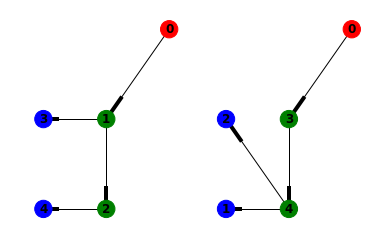

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_node(0,pos=(2,2)), G.add_node(1,pos=(1,1)), G.add_node(2,pos=(1,0)),G.add_node(3,pos=(0,1)),G.add_node(4,pos=(0,0))
pos1=nx.get_node_attributes(G,'pos')
G.add_edges_from([(0, 1),(1, 2), (1, 3),(2, 4)])
color_map_G = ['red','green','green','blue','blue']

F = nx.DiGraph()
F.add_node(0,pos=(2,2)), F.add_node(3,pos=(1,1)), F.add_node(4,pos=(1,0)),F.add_node(2,pos=(0,1)),F.add_node(1,pos=(0,0))
pos2=nx.get_node_attributes(F,'pos')
F.add_edges_from([(0, 3),(3, 4), (4, 2),(4, 1)])
color_map_F = ['red','green','green','blue','blue']

plt.subplot(121)
nx.draw(G,pos1,node_color=color_map_G, with_labels=True,font_weight='bold')
plt.subplot(122)
nx.draw(F,pos2,node_color=color_map_F,with_labels=True,font_weight='bold')
plt.show()

As you can see on the two graphs above, the streaming capacity of every node is not fully used (3 & 4 for graph 1 and 1 & 2 for graph 2). Thus, a Multi-Tree would benefit to use the upload capacity of every peer.

The construction of a Multi-Tree is not an exact science since it requires to solve difficult combinatorial optimization problems (we will cover this in section 3). But the basic idea is to put the peers with a lot of leftover upload capacity higher up in the Multi-Tree and in some special cases, the equation is easy to solve ! Let me show you: let's assume that every peer $i = 1,...,N$ has a capacity of download illimited while the upload capacity $u_i$ is limited. Then we want to prove that the total amount of time of downloading, $T$ is the larger of the two following numbers : 

$$ T = max\left\{\frac{F}{u_s} , \frac{NF}{u_s + \sum_{i=1}^Nu_i}\right\} \;\;\;\;  \iff  \;\;\;\;
   r_{max} = min\left\{ u_s , \frac{u_s + \sum_{i=1}^Nu_i}{N} \right\} $$

where $F$ is the size of the file, and $u_s$ is the upload capacity of the server.  This relation can be proved using its inversed relation : the maximum broadcast rate $r_{max}$ is just the inverse of the first relation, it can also be used to solve the problem. Thus, two different cases appear : one in which the upload capacity of the server $u_s$ is smaller then the mean of every peer's capacity, the second one being the opposite.

### 2.1 Case 1:  $u_s \leq \frac{(u_s + \sum_{i=1}^Nu_i)}{N}$

In this situation, the maximum broadcast rate of $r_{max} = u_s$ can be supported. So the multi-tree would be a combinaison of N two-hop trees where each tree is composed like the following :

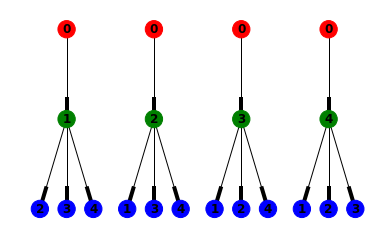

In [11]:
G = nx.DiGraph()
G.add_node(0,pos=(2,4)), G.add_node(1,pos=(2,3)), G.add_node(2,pos=(1.5,2)),G.add_node(3,pos=(2,2)),G.add_node(4,pos=(2.5,2))
G.add_edges_from([(0, 1),(1, 2), (1, 3),(1, 4)])
pos1=nx.get_node_attributes(G,'pos')

F = nx.DiGraph()
F.add_node(0,pos=(2,4)), F.add_node(2,pos=(2,3)), F.add_node(1,pos=(1.5,2)),F.add_node(3,pos=(2,2)),F.add_node(4,pos=(2.5,2))
F.add_edges_from([(0, 2),(2, 1), (2, 3),(2, 4)])
pos2=nx.get_node_attributes(F,'pos')

D = nx.DiGraph()
D.add_node(0,pos=(2,4)), D.add_node(3,pos=(2,3)), D.add_node(1,pos=(1.5,2)),D.add_node(2,pos=(2,2)),D.add_node(4,pos=(2.5,2))
D.add_edges_from([(0, 3),(3, 1), (3, 2),(3, 4)])
pos3=nx.get_node_attributes(D,'pos')

S = nx.DiGraph()
S.add_node(0,pos=(2,4)), S.add_node(4,pos=(2,3)), S.add_node(1,pos=(1.5,2)),S.add_node(2,pos=(2,2)),S.add_node(3,pos=(2.5,2))
S.add_edges_from([(0, 4),(4, 1), (4, 2),(4, 3)])
pos4=nx.get_node_attributes(S,'pos')
color_map = ['red','green','blue','blue','blue']

plt.subplot(141)
nx.draw(G,pos1,node_color=color_map,with_labels=True,font_weight='bold')
plt.subplot(142)
nx.draw(F,pos2,node_color=color_map,with_labels=True,font_weight='bold')
plt.subplot(143)
nx.draw(D,pos3,node_color=color_map,with_labels=True,font_weight='bold')
plt.subplot(144)
nx.draw(S,pos4,node_color=color_map,with_labels=True,font_weight='bold')
plt.show()

In this configuration, we can clearly see that the trees that have peers with a high upload capacity near the root will stream the packets at a higher rate. 

Since the total upload required for the server equals its capacity, $\sum_{i=1}^Nr_i = u_s$, we can find that each tree's rate is equal to : 
$$r_i = \frac{u_i}{\sum_{j=1}^Nu_j}u_s$$.

Given this relation, we can find the total upload capacity required for every peer i :

$$N u_s \leq (u_s + \sum_{i=1}^Nu_i) \Longrightarrow N u_s \left(\frac{u_i}{\sum_{j=1}^Nu_j}\right) \leq \frac{u_i u_s}{\sum_{j=1}^Nu_j} + u_i \iff (N - 1) \frac{u_i}{\sum_{j=1}^Nu_j} u_s \leq u_i$$

It implies that the total upload capacity required for each peer would equal :
$$ (N - 1) r_i = (N - 1) \frac{u_i}{\sum_{j=1}^Nu_j} u_s \leq u_i$$ 

It now means that each peer in the Multi-Tree Structure receives a data stream directly from the server and it receives also (N-1) streams from the other peers. The result is that each peer i will have a broadcast rate equals to : 
$$r_{max} = r_i + \sum_{j \neq 1}^Nr_j $$

Hence, looking back at the equation of the total downloading time of a file will be 
$$T = \frac{F}{u_s}$$

### 2.1 case 2: $u_s > \frac{(u_s + \sum_{i=1}^Nu_i)}{N}$

In this situation, the maximum broadcast rate supported would be equal to $r_{max} = \frac{(u_s + \sum_{i=1}^Nu_i)}{N}$ and the server upload capacity is large enough to stream to every peer directly in addition to stream via a two hop Multi-tree system like in the first case ! Thus, the Multi-Tree of such a configuration would look like just the first case adding this sub-tree : 

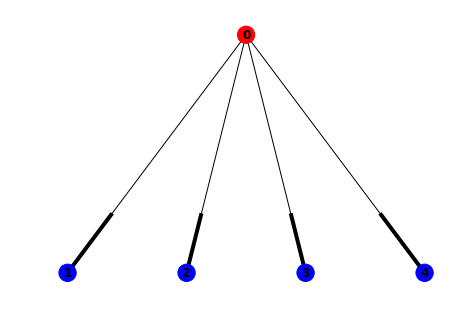

In [12]:
G = nx.DiGraph()
G.add_node(0,pos=(2.5,4)), G.add_node(1,pos=(1,3)), G.add_node(2,pos=(2,3)),G.add_node(3,pos=(3,3)),G.add_node(4,pos=(4,3))
G.add_edges_from([(0, 1),(0, 2), (0, 3),(0, 4)])
pos1=nx.get_node_attributes(G,'pos')
color_map = ['red','blue','blue','blue','blue']
nx.draw(G,pos1,node_color=color_map,with_labels=True,font_weight='bold')
plt.show()

In this case, each i-th two hop tree of the Multi-tree would stream with a constant rate $ r_i = \frac{u_i}{N-1}$, it thus means that the total upload capacity required for each peer i is $u_i=(N-1) r_i$. 

Also, the (N+1)-th tree (the server client subtree) would carry a rate of $ r_{N+1} = \frac{u_s - \frac{\sum_{i=1}^Nu_i}{N-1}}{N}$.

Furthermore the total upload capacity required for the server is equal to the sum of every rate passing through the first peer of each two hop tree and the product of N times the rate throught out each peer in the one hop tree : 
$$ \sum_{i=1}^Nr_i + N \cdot r_{N+1} = \sum_{i=1}^N\frac{u_i}{N-1} + N \cdot \frac{u_s - \frac{\sum_{i=1}^Nu_i}{N-1}}{N} = u_s $$ 
In this formula, we see second equality that the first term cancels out with the third one and the result is equal to $u_s$. 

In that case, the total broadcast rate at which any peer i in the network receives informations is the sum of two data streams from the server we just explained here-above $r_{server}= r_i + r_{N+1}$, but it also receives $N-1$ additional data streams from the other $N-1$ peers: 

\begin{align}
    r_{max} = r_{server} + \sum_{j \neq i}r_j  
    &\iff r_{max}=\frac{u_i}{N - 1} + \frac{u_s - \frac{\sum_{i=1}^Nu_i}{N-1}}{N} + \sum_{j \neq i} \frac{u_j}{N-1} \\
    &\iff r_{max}=\frac{u_s}{N} +\frac{N\sum_{i=1}^N u_i-\sum_{i=1}^N u_i}{N(N-1)} \\
    &\iff r_{max}=\frac{u_s}{N} +\frac{\sum_{i=1}^N u_i(N-1)}{N(N-1)} \\
    &\iff r_{max} = \frac{u_s + \sum_{i=1}^Nu_i}{N}
\end{align}

Knowing the maximal broadcast rate, we can determine the total amount of time to upload a file looking back at the equation in the introduction of this section : 

$$T =  \frac{NF}{u_s + \sum_{i=1}^Nu_i}$$


### 2.3 Example problem
Let us show you what is explained above with a little example, we consider this graph : The peer "0" is the source with an upload capacity $u_0 = 2$. The remaining peers have  the following upload capacity : $ u_1 = 2 , u_2 = 3 , u_3 = 2 , u_4 = 3$ (the units of the upload capacity is in Mbps-Megabits per second). The other peers are labelled as "yellow" because they can either be helpers or receivers.

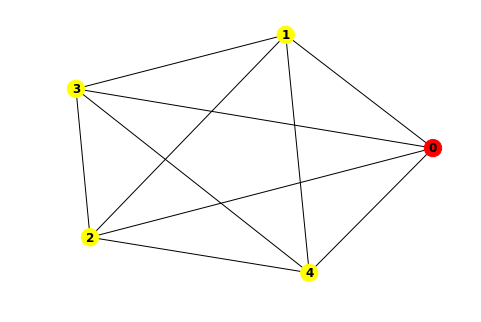

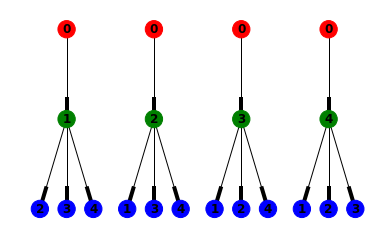

In [13]:
A = nx.complete_graph(5)
color_map = ['red','yellow','yellow','yellow','yellow']
nx.draw(A,node_color=color_map,with_labels=True,font_weight='bold')
plt.show()

G = nx.DiGraph()
G.add_node(0,pos=(2,4)), G.add_node(1,pos=(2,3)), G.add_node(2,pos=(1.5,2)),G.add_node(3,pos=(2,2)),G.add_node(4,pos=(2.5,2))
G.add_edges_from([(0, 1),(1, 2), (1, 3),(1, 4)])
pos1=nx.get_node_attributes(G,'pos')

F = nx.DiGraph()
F.add_node(0,pos=(2,4)), F.add_node(2,pos=(2,3)), F.add_node(1,pos=(1.5,2)),F.add_node(3,pos=(2,2)),F.add_node(4,pos=(2.5,2))
F.add_edges_from([(0, 2),(2, 1), (2, 3),(2, 4)])
pos2=nx.get_node_attributes(F,'pos')

D = nx.DiGraph()
D.add_node(0,pos=(2,4)), D.add_node(3,pos=(2,3)), D.add_node(1,pos=(1.5,2)),D.add_node(2,pos=(2,2)),D.add_node(4,pos=(2.5,2))
D.add_edges_from([(0, 3),(3, 1), (3, 2),(3, 4)])
pos3=nx.get_node_attributes(D,'pos')

S = nx.DiGraph()
S.add_node(0,pos=(2,4)), S.add_node(4,pos=(2,3)), S.add_node(1,pos=(1.5,2)),S.add_node(2,pos=(2,2)),S.add_node(3,pos=(2.5,2))
S.add_edges_from([(0, 4),(4, 1), (4, 2),(4, 3)])
pos4=nx.get_node_attributes(S,'pos')
color_map = ['red','green','blue','blue','blue']

plt.subplot(141)
nx.draw(G,pos1,node_color=color_map,with_labels=True,font_weight='bold')
plt.subplot(142)
nx.draw(F,pos2,node_color=color_map,with_labels=True,font_weight='bold')
plt.subplot(143)
nx.draw(D,pos3,node_color=color_map,with_labels=True,font_weight='bold')
plt.subplot(144)
nx.draw(S,pos4,node_color=color_map,with_labels=True,font_weight='bold')
plt.show()

In this case, we are facing the case 1 explained above ; the upload capacity of the server is less than the mean of the upload capacity if the network. The resulting multitree is drawn just above!

The maximum multicast rate $r_{max}$ will be the sum of every peer's rate : $ r_{max}  = 2 + 3 + 3 + 2 = 10$ Mbps . For a file of size F = 100Mb, it will thus take 10 seconds to download it.

## 3. Primal-Dual algorithm
The method we have introduced is not general, it only works for the certain case. Then how should we assess the capacity of a general graph?  Here we show the method proposed by Sengupta et al [2] ,  which solves the problem efficiently by using primal-dual inner and outer loops. Although the method can also solve multiple session problems where there are several servers that send different informations, here we focus on the single session, as we have seen so far. 


### 3.1 Problem formulation (combinatorial optimization)
Here we first show the mathematical formulation of the P2P model. Let us denote the following notations:

- $V$: set of all nodes
- $r$: streaming rate
- $s$: server node (single) 
- $R$: set of receivers
- $H$: set of helpers
- $T$: set of all possible overlay trees on the underlay graph
- $u_v$: capacity of node $v \in V$
- $y_t$: rate of tree $t$
- $m_{v,t}$: outgoing degree of node $v$ in tree $t$, (we sometimes use $m(v)$ for a certain tree)
- $M(v)$: degree bound of node $v \in V$
- $p(v)$: price of node $v \in V$

A given packet starts from the server $s$, and it traverses all receivers $R$. As we discussed before, in order to get the efficient rate, we apply the *multitree*, which overlays trees simultaneously. Each tree $t$ has a rate $y_t$ and we want to maximize the streaming rate which corresponds to the sum of $rates$ among all possible trees, i.e. $r = \sum_{t \in T}y_t$. If we do not use a tree $t$, then its rate is simply zero: $y_t = 0$.  $m_{v,t}$ is the number of outgoing degree of node $v$ in tree $t$. Thus,  node $v$'s uplink rate in tree $t$ can be defined as $m_{v,t}y_t$, and its sum over all trees must be smaller than the capacity: $\sum_{t\in T}m_{v,t} y_t \leq u_v$.
We also introduce the degree bound for a node $M(v)$. It comes from the practical reason: in BitTorrent, even though we can have about 50 neighours in a graph, the number of peer to upload is limited to five.  Obviously, $m_{v,t} \leq M_v$.

Now our problem can be expressed in the following combinatorial optimizatoin problem. 
\begin{align}
& \max & & r  =\sum_{t \in T}y_t \\
& \ \text{s.t.} & & \sum_{t\in T}m_{v,t} y_t \leq u_v& \forall v\in V\\
& & & y_t \geq 0 & \forall t\in T\\
\end{align}

The bottleneck of  this formulation is that it has too many variables $y_t$, since usually the number of possible trees $|T|$ grows exponentially with the number of nodes in the graph. Hence, let's take the dual of the problem as it is usually done in the literature. 
\begin{align}
& \min & & \sum_{v \in V}u_vp(v)  \\
& \ \text{s.t.} & & \sum_{v \in V}m_{v,t}  p(v)\geq 1 & \forall t\in T\\
& & & p(v) \geq 0 & \forall v\in V\\
\end{align}

The dual variable $p(v)$ can be intrepreted as the price of the node to go through, and we minimize the cost incurred when the capacity of all nodes are fully used. The cost of using node $v$ in tree $t$ is $m_{v,t}p(v)$, and thus the price of tree $t$ is the sum among all nodes: $\sum_{v\in V} m_{v,t}p(v)$. Therefore, the constrain represents that we have to build trees such that its prices are at least 1.  This formulation seems nice because the number of variables decreases drastically, it is just the number of nodes. However, it has an exponential number of constraints, and neither of them are easy to solve directly. In the end, the two above formulations allow us to build a much simpler problem, finding the smallest price tree, by primal-dual update loop.

Let us see the details of the algorithm. It can attain $1+\zeta$-factor of optimality (i.e. if you set $\zeta = 10\%$, it is guaranteed that you can obtain the solution within $10\%$ error). Before introducing the algorithm let's define $Q(t,p)$, the left hand side of the constraint of the dual problem, which can be interpreted as the *price* of the tree $t$. 

$$ Q(t,p) =\sum_{v \in V}m_{t,v}  p(v) $$

A set of price $p(\cdot)$ is feasible for the dual, if and only if :

$$\min_{t\in T} Q(t,p)  \geq 1$$

It means that the minimum price of the trees must be grater than 1, thus we  do not have to look at all trees, but just need to check the price of the smallest price tree.

The algorithm consists in a two-level iteration:
- an **outer loop**, in which the whole flow $Y$ is augmented based on the pricing variables $p(v)$ in the primal solution and dual variables are updated iteratively,
- an **inner loop**, in which the smallest price tree is erected under the governance of the pricing variables.

The description of the  algorithm is as follows.


#### Algorithm
 Initialization: set the price of each node as $p(v) = \frac{\delta(\zeta)}{u_v}$.

Then, implement the following steps until the price of the smallest price tree is greater than 1.
1. Find the tree $\bar{t}$ which minimizes the price, $\bar{t} = \text{argmin}_{t\in T} Q(t,p) $. We call $\bar{t}$  as  a *smallest price tree*  (**SPT**)
2. Obtain the maximum flow of SPT: at least one of the internal nodes of $\bar{t}$ can overflow its upload capacity. The flow $y$ on $\bar{t}$ can be defined as $y = \min_{v \in I(\bar{t})} \frac{u_v}{m_{v,\bar{t}}}$ where $I(\bar{t})$ is the set of internal nodes of  $\bar{t}$.
3. Update the price for each node: $p(v) \leftarrow p(v) \left( 1+ \frac{\epsilon(\zeta) m_{v,\bar{t}} y}{u_v} \right), \ \ \forall v \in I(\bar{t})$
4. Increment the whole flow $Y$ by $y$

After the termination of the loop, we have to scale down the total flow $Y$ to be the rate of the graph. 

### 3.2 Smallest price tree (SPT)
Now the problem is that "How to find the SPT in efficient way?" We tackle this issue for the following five underlay graph topologies:
1. Full mesh graph, no degree bound, no helper
2. Full mesh graph, with degree bound, with helper
3. Full mesh graph, no degree bound, no helper
4. Full mesh graph, with degree bound, with helper
5. General graph, no degree bound, no helper

We precise that a helper node is a node by which transits packets that the node do not need, it does it only to help other nodes.

The larger the index, the more complicated to solve. Let's look at all the cases one by one.

#### 3.2.1 Type1: Full mesh no degree bound no helper
This topology is actually the same as we have seen in section 2.

Finding SPT is quite easy. Picking the smallest price node $v^* = \text{argmin}_{v\in V}p(v) $ (if there are several smallest nodes, say choosing one randomly among them), and if it is the server build a 1-hop tree: $s \to v $ for $v \in R$. Otherwise just build the 2-hop tree such that $s \to v^*$ and $v^* \to v$ for $v \in R\ \{v^*\}$. Here is an example.

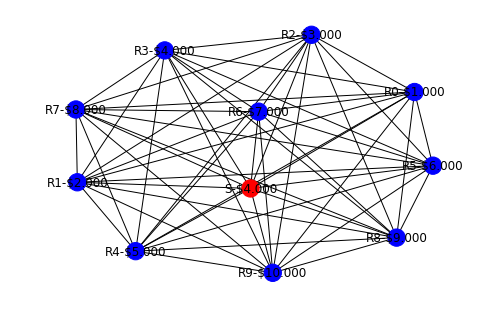

In [28]:
from source import *

N = 10  # number of receivers
Capacity = 20
inf = float('inf')
# initialization of nodes
server = Node('s', Capacity, inf, None, 4)
receivers = []
for i in range(N):
    receivers.append(Node('r', Capacity, inf, i, i+1))  # initialize the receivers
graph_1 = Graph(1, server, receivers)
plot_graph(graph_1,True)  # show full mesh underlay graph


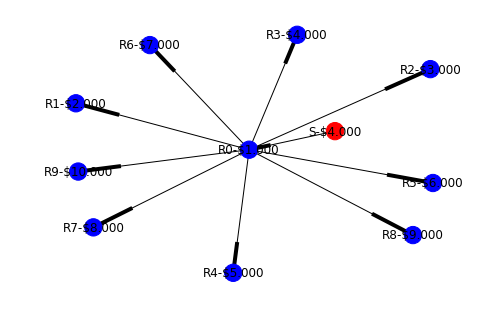

In [29]:
# find the SPT
t, price = smallest_price_tree1(graph_1)  
plot_tree(t,True) # plot
# it will be 2- hop tree

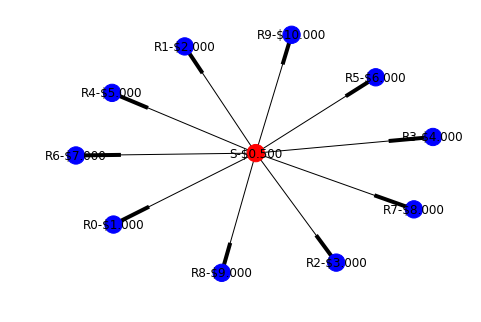

In [30]:
# when the price of the server is cheapest
server.price = 0.5
t, price = smallest_price_tree1(graph_1)  
plot_tree(t,True) # plot
# 1-hop tree, Obvious ...... :) 

#### 3.2.2 Type2: Full mesh no degree bound with helper
With helper nodes, it is a little bit more complicated. We introduce the *effective price*  which is defined as follows:

\begin{equation}
\hat{p}(v) = 
\begin{cases}
p(v)    &\text{if } v \in s \cup R\\
p(v)\frac{|R|}{|R|-1}    &\text{if } v \in H
\end{cases}
\end{equation}

The idea is the following: if a SPT has a helper node in it, the number of nodes in the tree will be higher than without any helper. When we asses the price of the nodes we indeed have to consider that aspect, the smallest price can be computed as:

$$ p_s + \min \{ (N-1)p_s, (N-1)p_r, Np_h\}$$

where $p_s, p_r$ and $p_h$ represent the price of the server, the minimum price of receivers and the minimum price of the helpers respectively. To compute the SPT we fall in one of the following three cases: 1) the server supports all the receivers, 2) the server supports the min effective price receiver, and the min effective price receiver then takes care of all the other receivers, and 3) the server uses the min effective price helper and the min price helper then supports all the receivers. 


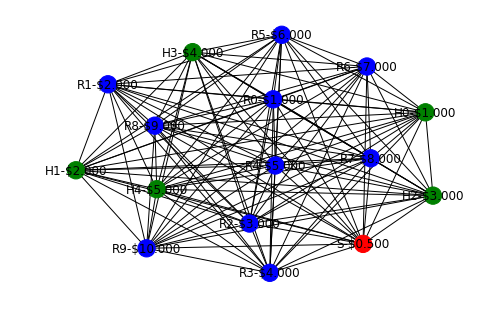

In [31]:
# Example
# add the helpers
helpers =[]
H = 5
for i in range(H):
    helpers.append(Node('h', Capacity, inf, i, i+1))
    
graph_2 = Graph(2, server, receivers,helpers)
plot_graph(graph_2,True) 

1) When the server has the min effective price

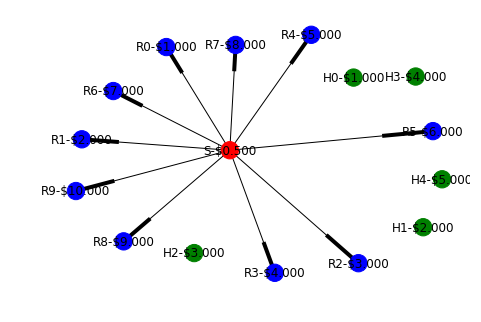

Price : $5.0


In [32]:
# compute SPT
t2, price2 = smallest_price_tree2(graph_2)  
plot_tree(t2,True) # plot
print('Price : ${0}'.format(price2))
## helpers are not in the SPT

2) When a receiver has the min effective price

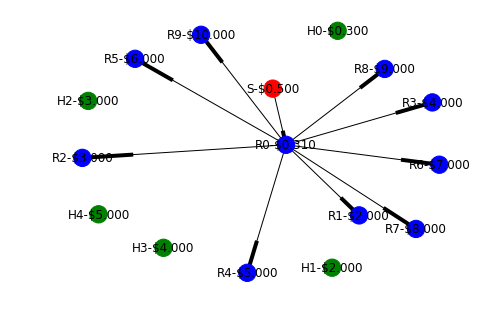

Price : $3.290


In [33]:
#  the price of cheapest helper <  that of receivers: 
# but it will not be selected...-> because measure in effective price!
helpers[0].price = 0.3
receivers[0].price = 0.31
t2, price2 = smallest_price_tree2(graph_2)  
plot_tree(t2,True) # plot
print('Price : ${0:.3f}'.format(price2))
# 2-hop tree without helpers, node 'H0' is the cheapest but not selected
# because of the efficient price

3) When a helper has the min effective price

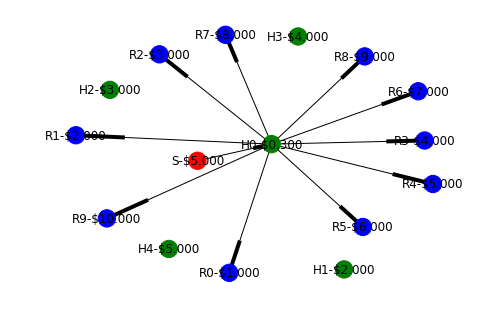

Price : $8.0


In [34]:
# when a helper is the cheapest
server.price = 5
receivers[0].price = 1
t2, price2 = smallest_price_tree2(graph_2)  
plot_tree(t2,True) # plot
print('Price : ${0}'.format(price2))
# 2-hop tree

#### 3.2.3 Type3: Full mesh with degree bound no helper
If there is degree bound, we need to build the tree with more than a 2-hop. Let's sort the receivers w.r.t. to the price:

$$p(1) \leq p(2) \leq ... \leq p(|R|) $$

The idea of SPT is to build a tree by using the cheapest nodes as much as possible. Precisely, we first define the following function $I$:

$$  I(n,M) = \min \{ i \in R : \sum_{v=1}M(v) \geq n \}$$

where $M$ is the set of all the degree bounds. 
It can be interpreted as "Receiver 1 to Receiver $I(n,M)$ can support $n$ nodes". Considering server supports $m(s)$ receivers, then the SPT is to support 

\begin{equation}
m(v) = 
\begin{cases}
m(s)    &\text{if } v = s \\
m(v)   &\text{if } 1  \leq v < I(|R|-m(s)),M)   \\
m_I   &\text{if } v =    I(|R|-m(s)),M)   \\
0 &\text{if } v >  I(|R|-m(s)),M)  
\end{cases}
\end{equation}

where $ m_I  = |R| - m(s) \sum_{j = 1}^{  I(|R|-m(s)),M) -1}$, i.e. the rest of the nodes that are not supported by the receivers 1 to $m_I -1$. 

The SPT is the minimum among $1 \leq m(s) \leq M(s)$. 

In the mathematical form, the reader might think that it seems complicated, it indeed is, however the idea behind the mathematical form is quite simple. To show this we're going to go through two examples.

* Let's first look at the following small example.

<html>
<body>

<img src="images/fig1.png" width="700" >

</body>
</html>

In this example, we have the server with price $\$5$, and the four receivers with prices set from $\$1$ to $\$4$. Theegree bound is set to 2 for all nodes.  As can be seen, we would like to use the cheapest node, 1 then node 2... and so on. Hence, the SPT is either case (a) or (b), indeed  it is (a) here.  

* We now present a more complex example, with the full mesh and the SPT that we derive using the presented algorithm.

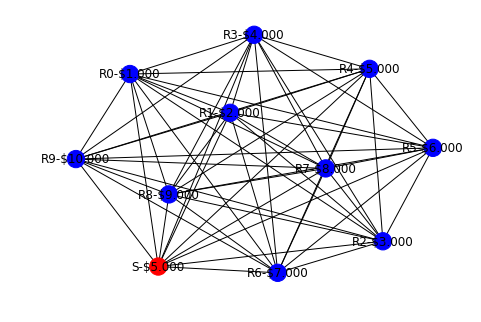

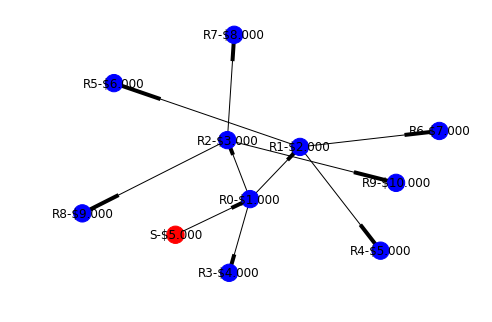

Price : $23.000


In [35]:
##  Example
M = 3 # degree bound is set to 3 for all nodes
graph_3 = Graph(3, server, receivers, None, M)
plot_graph(graph_3,True)  # visualization
# Note that underlay graph is still full mesh

# compute SPT
t3, price3 = smallest_price_tree3(graph_3)  
plot_tree(t3,True) # plot
print('Price : ${0:.3f}'.format(price3))
# the smallest price nodes are fully using their degree capacities

#### 3.2.4 Type4: Full mesh with degree bound with helper
Here, we study the most general case in the full mesh graph.  Let us consider the following assumptions:

- Degree bound of the server is set to infinity: $M(s) = \infty$
- Degree bound $M(v)$ is same among all receivers and helpers, $M_p$

As we have seen before, when there are helper nodes, we have to assess them by the *effective price* since their participation increases the number of edges and nodes than helper free ones.  Hence we have to compare with a "proper" measure. Let' look at the following example.
<html>
<body>

<img src="images/fig2.png" width="600" >

</body>
</html>

Tree (a) has a helper node $H_1$, whose number of edges is 6.  We replace it by a leaf node $R_5$, and to keep the degree of its parent node $R_3$, we take one of the helper's child, $R_2$ here. Then we now posse a new tree (b) of which the number of total edges 5, degresesd by 1. Hence, their differences of price can be expressed as:

$$ Q(\text{tree (b)}, p) -Q(\text{tree (a)}, p) =  m({R_5}) p(R_5)  - m(H_1)p(H_1)  =2 \times p(R_5) - 3\times p(H_1) $$

Thus, we have to compare $\frac{mp(v_h)}{m-1}$ with $p(v_r)$ where $m$ is the degree of the helper $v_h$, i.e. the effective price of helpers will be $\hat{p}(v_h) = \frac{m}{m-1}p(v_h)$ for all $v_h \in H$.  Let's have a look at the small example.

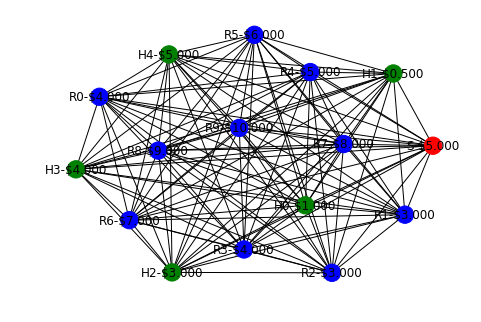

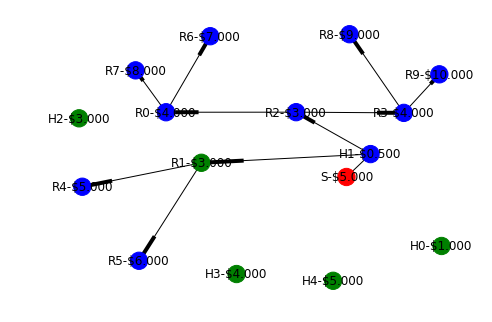

Price : $34.000


In [46]:
## Example 
M = 2  # degree bound
receivers[0].price = 4
helpers[0].price = 1
graph_4 = Graph(4, server, receivers, helpers, M)  # Form 4: Full mesh, With degree bound, With helper
plot_graph(graph_4,True)  # visualization
# a bit messy....

# find SPT
t4, price4 = smallest_price_tree4(graph_4, M)
plot_tree(t4,True) # plot
print('Price : ${0:.3f}'.format(price4))

#### 3.2.5 Type5: General Graph, no degree bound no helper = minimum cost arborescence problem 

Finally, we follow the general graph case whit the simplest case, where there is no helpers and no degree bound.  Actually, the case where there are helpers or degree bounds, we cannot obtain the solution within $(1+\zeta)$ factor of the optimum.

Unlike so far, a node is not directly connected to all the others yet some of them. In this case, the SPT problem will be *the minimum cost arborescence problem*, which is originally solved by [3].
It can be considered as directed version of minimum spanning tree problem with a source node. 

An algorithm to solve this problem is known as *Edmonds' algorithm*. It mainly consists of two parts: 1) contracting 2) expanding. The idea of 1) contracting is that if there is a cycle in a graph, we make the nodes in the cycle to contract and regard them as a single node. We continue this process until finding an arborescence tree.  Then we do 2) expanding, i.e. expand the contracted nodes so as to keep arborescence property. Let's look the following toy graph: 

<html>
<body>

<img src="images/ed1.png" width="400" >

</body>
</html>

where the price of server is $\$5$  and the receiver $i$'s price is $\$i$.  Note that  we ommit the edges form receiver 1 and 2 to the server since it is meaningless. 

Following figures demonstrate Edmonds' algorithm step by step. 

<html>
<head>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<title>Untitled Document</title>
</head>
<body>    
<p><strong>Contraction Stage</strong></p>
<div style=" background-color:white; overflow:scroll; overflow-x: scroll; overflow-y: hidden;">
       <div style="width:10000px;">
       
       <figure style=" float:left; display:inline">
          <img src="Images/ed1.png"  width="250" hspace="20" vspace="5">
          <figcaption style="text-align: center;">(1) Original Graph</figcaption>
        </figure>
       <figure style=" float:left; display:inline">
          <img src="Images/ed2.png"  width="250" hspace="20" vspace="5">
          <figcaption style="text-align: center;">(2) Find minimum incoming edges</figcaption>
        </figure>
       <figure style=" float:left; display:inline">
          <img src="Images/ed3.png"  width="250" hspace="20" vspace="5">
          <figcaption style="text-align: center;"> (3) Update cost</figcaption>
        </figure>
 </div>        
</div>    

<div style=" background-color:white; overflow:scroll; overflow-x: scroll; overflow-y: hidden;">
       <div style="width:10000px;">
       <figure style=" float:left; display:inline">
          <img src="Images/ed4.png"  width="250" hspace="20" vspace="5">
          <figcaption style="text-align: center;">(4) Find a cycle and contraction</figcaption>
        </figure>
       <figure style=" float:left; display:inline">
          <img src="Images/ed5.png"  width="250"　hspace="20" vspace="5">
          <figcaption style="text-align: center;">(5) Create a new graph</figcaption>
        </figure>
       <figure style=" float:left; display:inline">
          <img src="Images/ed6.png"  width="250" hspace="20" vspace="5">
          <figcaption style="text-align: center;">(6) Find minimum incoming edges </figcaption>
        </figure>
</div>        
</div> 

 
<div style=" background-color:white; overflow:scroll; overflow-x: scroll; overflow-y: hidden;">
       <div style="width:10000px;">
       <figure style=" float:left; display:inline">
          <img src="Images/ed7.png"  width="250" hspace="20" vspace="5">
          <figcaption style="text-align: center;">(7) Update the price, find a cycle and contraction</figcaption>
        </figure>
       <figure style=" float:left; display:inline">
          <img src="Images/ed8.png"  width="250" hspace="20" vspace="5">
          <figcaption style="text-align: center;">(8) Reach an arborescence</figcaption>
       </figure>
</div>
 </div>
 
<p><strong>Expansion Stage</strong></p>

<div style=" background-color:white; overflow:scroll; overflow-x: scroll; overflow-y: hidden;">
       <div style="width:10000px;">
<figure style=" float:left; display:inline">
          <img src="Images/ed9.png"  width="250" hspace="20" vspace="5">
          <figcaption style="text-align: center;">(9) Expansion 1</figcaption>
        </figure>      
       
       <figure style=" float:left; display:inline">
          <img src="Images/ed10.png"  width="250" hspace="20" vspace="5">
          <figcaption style="text-align: center;">(10) Expansion 2</figcaption>
        </figure>
       <figure style=" float:left; display:inline">
          <img src="Images/ed11.png"  width="250" hspace="20" vspace="5">
          <figcaption style="text-align: center;">(11)  minimum cost arborescence</figcaption>
        </figure>
       
</div>
 </div>
 
 
</body>
</html>

We also see the Pyhon example below.

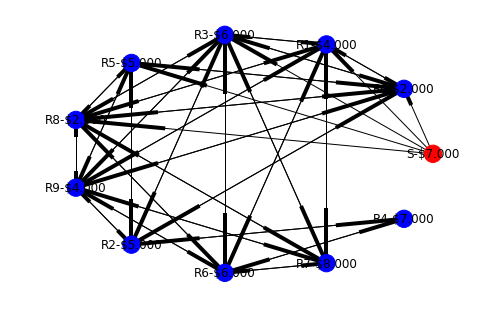

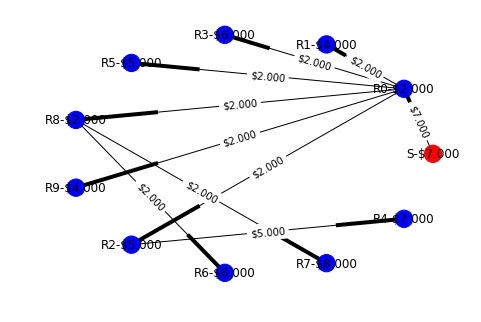

In [37]:
## Example: General Graph
# parameters
N = 10 #number of receivers
p = 0.5  # probability of having edges
price_vec = [7,2,4,5,6,7,5,6,8,2,4]  # price vector: price_vec[0] for the server, 1 to 11 for the receivers

# build an general underlay graph (randomly)
underlay_graph, color_map, node_labels = build_general_graph(N, p, price_vec, 1,True)

# visualize the neighborhood relationship (underlay Graph)
pos = nx.shell_layout(underlay_graph)
nx.draw(underlay_graph, node_color=color_map, pos=pos, labels=node_labels)
plt.show()


## find the minimum cost arborescence 
t = nx.algorithms.tree.branchings.minimum_spanning_arborescence(underlay_graph)  # use the function of NetworX
# retrieve the labels
edge_labels = {}
for e in t.edges(data=True):
    edge_labels.update({(e[0], e[1]): '$' + str.format('{0:.3f}', e[2]['weight'])})
# visualization
pos = nx.shell_layout(t)
nx.draw(t, pos=pos,node_color=color_map, labels=node_labels)
nx.draw_networkx_edge_labels(t, pos=pos, edge_labels=edge_labels)
plt.show()

## 4. Numerical result
Here we implement the whole primal dual algorithm for each formulation. The capacities of the nodes are defined as follow:
 - Server: 768 Kbps
 - Receivers and helpers: 64Kbps (2.8%), 128Kbps (14.3%), 256Kbps (4.3%), 384Kbps (23.3%), 768Kbps (55.3%)
 
($\cdot$) represents the probability distribution on the upload capacity.


### 4.1 Full Mesh Graph

Loop: 1000, Time: 0.032, SPT Price: $0.000000
Loop: 2000, Time: 0.077, SPT Price: $0.000000
Loop: 3000, Time: 0.144, SPT Price: $0.000000
Loop: 4000, Time: 0.186, SPT Price: $0.000000
Loop: 5000, Time: 0.234, SPT Price: $0.000000
Loop: 6000, Time: 0.292, SPT Price: $0.000000
Loop: 7000, Time: 0.335, SPT Price: $0.000000
Loop: 8000, Time: 0.375, SPT Price: $0.000000
Loop: 9000, Time: 0.426, SPT Price: $0.000000
Loop: 10000, Time: 0.476, SPT Price: $0.000000
Loop: 11000, Time: 0.536, SPT Price: $0.000000
Loop: 12000, Time: 0.574, SPT Price: $0.000019
Loop: 13000, Time: 0.607, SPT Price: $0.001605
Loop: 14000, Time: 0.645, SPT Price: $0.138416
Algorithm Finished
Number of loop: 14441, Total time: 0.662

Price of the final SPT  : $1.011
Value of dual objective : $601.549
Approx capacity rate    : $610.810


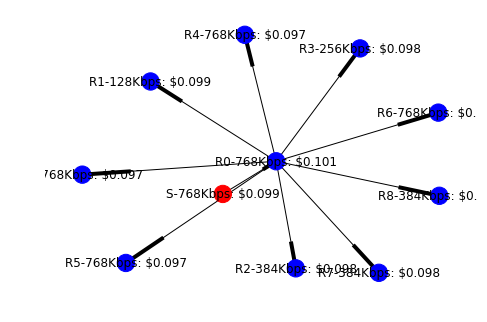

In [24]:
### FOR THE FIRST 4 FORMULATIONS: FULL MESH GRAPH

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from source import *

# Set Parameters 
#################################
#======== YOU CAN CHANGE ========##
N = 10  # number of receivers
H = 5  # number of helpers
M = 2  # Degree bound
#################################

V = N + H + 1  # number of nodes (+ server) with helper

# randomly choose the capacities by a proper distribution of the capacity
C = distribution(N)  # for RECEIVERS
Ch = distribution(H)  # for HELPERS
zeta = 0.1  # value for optimality
eps = 1 - 1 / np.sqrt(1 + zeta)  # rate for updating price
delta = (1 + eps) / (((1 + eps) * (N+1)) ** (1 / eps))  # value for the initial price Without helper
delta_h = (1 + eps) / (((1 + eps) * V) ** (1 / eps))  # value for the initial price With helper

# initialization of nodes
server = Node('s', 768, N + H + 1)  # fix the capacity to 768Kbps
receivers = []
helpers = []
for i in range(N):
    receivers.append(Node('r', C[i], N + H + 1, i))  # initialize the receivers
for i in range(H):
    helpers.append(Node('h', Ch[i], N + H + 1, i))  # initialize the helpers
graph_1 = Graph(1, server, receivers)                      # Form 1: Full mesh, No degree bound, No helper
graph_2 = Graph(2, server, receivers, helpers)       # Form 2: Full mesh, No degree bound, With helper
graph_3 = Graph(3, server, receivers, None, M)      # Form 3: Full mesh, With degree bound, No helper
graph_4 = Graph(4, server, receivers, helpers, M)  # Form 4: Full mesh, With degree bound, With helper

# initialize the price for all Forms
graph_1.ini_price(delta)
graph_2.ini_price(delta_h)
graph_3.ini_price(delta)
graph_4.ini_price(delta_h)

# solution of multi-casting, only works for Form 1
# print('Capacity of server: {0}'.format(server.capacity))
# print('Average capacity  : {0}'.format((sum(C) + server.capacity) / N))

#####################################
###########          Algorithm       ############
#####################################

### solve the problem for each formulation #####
#======== YOU CAN CHOOSE =============#

output_capacity, num_loop, min_price_tree = primal_dual_single_session(graph_1, eps)
# output_capacity, num_loop, min_price_tree = primal_dual_single_session(graph_2, eps)
# output_capacity, num_loop, min_price_tree = primal_dual_single_session(graph_3, eps)
# output_capacity, num_loop, min_price_tree = primal_dual_single_session(graph_4, eps)

plot_tree(min_price_tree)  # plot the final SPT


### 4.2 General Graph
A general graph, without degree bound and helpers.

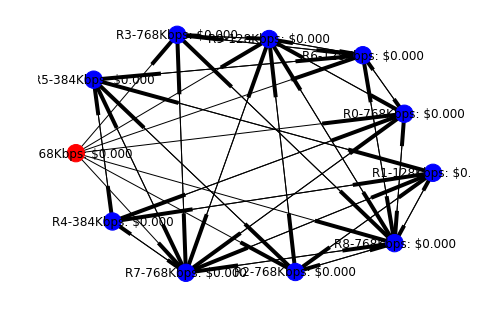

Loop: 1000, Time: 9.550, SPT Price: $0.000000
Loop: 2000, Time: 18.523, SPT Price: $0.000000
Loop: 3000, Time: 30.417, SPT Price: $0.000000
Loop: 4000, Time: 39.947, SPT Price: $0.000000
Loop: 5000, Time: 47.830, SPT Price: $0.000002
Loop: 6000, Time: 54.192, SPT Price: $0.008488
Algorithm Finished
Number of loop: 6562, Total time: 58.094

Price of the final SPT  : $1.012
Value of dual objective : $573.495
Approx capacity rate    : $572.824


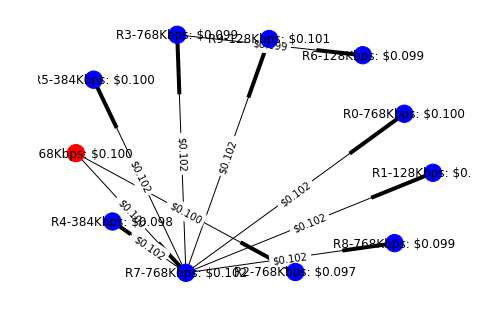

In [25]:
### FOR THE FORMULATION 5: GENERAL GRAPH, NO DEGREE BOUND, NO HELPERS

from source import *
import networkx as nx
import matplotlib.pyplot as plt

# Set Parameters 
#################################
#======== YOU CAN CHANGE =========#
N = 10  # number of receivers
p = 0.4  # probability of having edges
#################################


zeta = 0.1  # value for optimality, let 10%
eps = 1 - 1 / np.sqrt(1 + zeta)  # rate for updating price
delta = (1 + eps) / (((1 + eps) * (N + 1)) ** (1 / eps))  # value for the initial price Without helper

# build an general underlay graph (randomly)
underlay_graph, color_map, node_labels = build_general_graph(N, p, delta, 0)

# visualize the neighborhood relationship (underlay Graph)
pos = nx.spring_layout(underlay_graph)
nx.draw(underlay_graph, node_color=color_map, pos=pos, labels=node_labels, with_labels=True)
plt.show()

#####################################
###########          Algorithm       ############
#####################################
output_capacity, num_loop, min_price_tree, edge_labels, new_node_labels = primal_dual_form_5(underlay_graph, eps)

# visualization of the final SPT
nx.draw(min_price_tree, pos=pos, node_color=color_map, labels=new_node_labels)
nx.draw_networkx_edge_labels(min_price_tree, pos=pos, edge_labels=edge_labels)
plt.show()


## 5. Concept of Free Riders
Given the network of peer to peer represented by the directed graph below, could you spot free riders (by intuition, the definition will be given after) among the peers ?

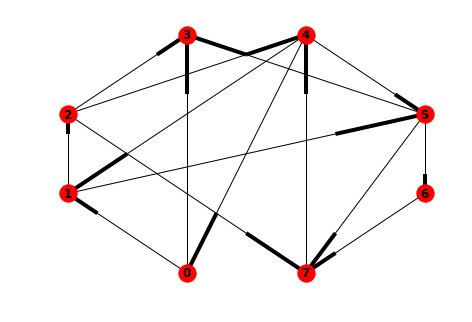

In [26]:
G=nx.DiGraph()
G.add_node(0,pos=(0,0)), G.add_node(1,pos=(-1,1)), G.add_node(2,pos=(-1,2)),G.add_node(3,pos=(0,3)),G.add_node(4,pos=(1,3))
G.add_node(5,pos=(2,2)), G.add_node(6,pos=(2,1)), G.add_node(7,pos=(1,0))
G.add_edges_from([(0, 1),(1, 2), (2, 3),(2, 4),(4, 5),(5, 6), (6, 7),(0, 3)])
G.add_edges_from([(1, 2),(1, 5), (5, 3),(5, 7),(4, 1),(4, 0), (2, 7),(7, 4)])
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos,with_labels=True,font_weight='bold')
plt.show()

If your intuition was correct, you should have identify that peer 3 is a free rider! For those of you who didn't find it, here is a little explanation. A free rider is a peer that doesn't contribute to help the network. It means that a free rider is only in the network to get but not to give.

He holds the following reasoning: 
- If others work hard, I can benefit from the good result even if I don't put in any effort.
- If others do not work hard, I have no reason to work hard for the others will benefit from the results of my work while I will only get a small share of what I produce.

If every user has such a reasoning, we can reasonably believe that it will greatly impact the system performance. We can have the intuition that in a P2P network, the behavior of free-riders has a negative effects for the collective welfare of the network (specially for the peers that contribute).

In this section we are building a model to study the impact of free-riding and how it can be dealt with in a P2P system, which is proposed by Feldman et al [4].

### 5.1 A game theoretic approach
With the aim to solve this problem, researches have used "Game Theory" to get rid of the free riders. Game Theory gives an insight of the strategy selection of each user of the network. Before each player selects their strategy, they take their own payoff functions and others’ strategies into consideration and they select the strategy that will benefit him the most, with a view to acheive the Nash Equilibrium.
 
Thus, each peer can decide between <font color='green'>Uploading ressources</font> and <font color='red'>Not Uploading ressource</font>. But if the peer selects between being altruist or being a free rider, he will have different payoffs functions depending on the situation he is in. Let's define several functions to continue :
- The quantity $Q_d$ is the ressources received and the quantity $Q_u$ is the ressources given.
- The profit of getting ressources would be denoted by $F_1(Q_d)$ and the cost of giving ressources would be $G(Q_u)$. Those two functions are both monotonously increasing functions, it means, for $F$, that the more the peer receives, the more profit he gets. For $G$, it means that, the more the peers give, the more it costs him.
- Moreover, the altruism is rewarded in the P2P network. The concept of helpers is crucial! It means that someone who help a lot will earn additionnal profit from social interaction. Therefore, the profit the helper win will be denoted by $F_2(Q_u)$. $F_2$ has the same charatesristics has the 2 previous functions. Finally, an altruist peer will likely upload ressources others peers request when the profit they earn from helping is larger than what it cost them to help, $ F_2' - G' > 0 $.
 
Knowing that, we can compute the payoff function for the different types of users in the network:
- The payoff function for <font color='green'>altruists</font> is $F_1(Q_d)+F_2(Q_u)- G(Q_u)$.
- The payoff function for <font color='red'>free riders</font> is $F_1(Q_d)-G(Q_u)$.
 
Finally, with two last assumptions, we will be able to compute the Nash Equilibrium:
- First, since a session of casting can be segmented in multiple finite sub-sessions. Finding the Nash Equilibrium of a sub-session, respectively "a period of a game", is the same thing as finding the Nash Equilibrium for the complete session, "the game"
- Second, the game models of the P2P network are called "incomplete". In a matter of fact, the users don't know the payoff functions of the others users. Consequently, each peer will choose the strategy that earns him the most profit.
 
When both peers are altruist, their best strategy to have is <font color='green'>Uploading ressources</font> and in doing so, the Nash Equilibrum of the system is acheived.
 
<table style="width:100%">
  <tr>
      <th> Altruist 1 \ Altruist 2 </th>
      <th><font color='green'>Uploading ressources</font></th>
      <th><font color='red'>Not Uploading ressources</font></th>
  </tr>
  <tr>
      <th><font color='green'>Uploading ressources</font></th>
      <th><font color='blue'> $F_1(Q_d^A) + F_2(Q_d^B) - G(Q_d^B), F_1(Q_d^B) + F_2(Q_d^A) - G(Q_d^A)$</th>
      <th> $F_2(Q_d^B) - G(Q_d^B) ,F_1(Q_d^B)$</th>
  </tr>
  <tr>
      <th><font color='red'>Not Uploading ressources</font></th>
      <th> $F_1(Q_d^A),F_2(Q_d^A) - G(Q_d^A)$</th>
      <th> $(0,0)$</th>
  </tr>
</table>
 
When one peer is altruist and the other one is a free rider, the altruist should still select to <font color='green'>Upload ressources</font> to get the best profit while between uploading and not uploading, the free rider should better <font color='red'>do nothing</font> the get the higher profit !
 
<table style="width:100%">
  <tr>
      <th> Altruist 1 \ Free Rider 1 </th>
      <th><font color='green'>Uploading ressources</font></th>
      <th><font color='red'>Not Uploading ressources</font></th>
  </tr>
  <tr>
      <th><font color='green'>Uploading ressources</font></th>
      <th> $F_1(Q_d^A) + F_2(Q_d^B) - G(Q_d^B), F_1(Q_d^B) - G(Q_d^A)$</th>
      <th> <font color='blue'> $F_2(Q_d^B) - G(Q_d^B) ,F_1(Q_d^B)$</font></th>
  </tr>
  <tr>
      <th><font color='red'>Not Uploading ressources</font></th>
      <th> $F_1(Q_d^A), - G(Q_d^A)$</th>
      <th> $(0,0)$</th>
  </tr>
</table>
 
When both peers are free riders, they would still get the higher profit is they select <font color='red'>not to upload ressources</font> ... But this Nash Equilibrium is very negative for the network !
 
<table style="width:100%">
  <tr>
      <th> Free Rider 1 \ Free Rider 2 </th>
      <th><font color='green'>Uploading ressources</font></th>
      <th><font color='red'>Not Uploading ressources</font></th>
  </tr>
  <tr>
      <th><font color='green'>Uploading ressources</font></th>
      <th> $F_1(Q_d^A) - G(Q_d^B), F_1(Q_d^B) - G(Q_d^A)$</th>
      <th> $-G(Q_d^B),F_1(Q_d^B)$</th>
  </tr>
  <tr>
      <th><font color='red'>Not Uploading ressources</font></th>
      <th> $F_1(Q_d^A) ,-G(Q_d^A)$</th>
      <th><font color='blue'> $(0,0)$</font></th>
  </tr>
</table>
 
Consequently, for the P2P Network, the altruist are valuable assets, they increase the efficiency of the network. In the other hand, the free riders, requesting without giving, will impede the wealth of the altruists and thus, the survival of the network ! Moreover, more complex "game theory" models exists! There are models that include the history of behavior of each peer. Thus, this consideration involves modified payoffs functions for both altruist user and free riders ! The modifications will depend on the amount of ressources shared (or not) in the past, the "reputation" of each user and given threshold that will implies sanctions for the bad behavior! This model is called the "Co-opetition Framework".

### 5.2 Building a model

Let $x \in [0,1]$ be the fraction of users that contribute, and $1-x$ the fraction of free-riders.  In a network, each user is defined by an intrinsic parameter, called the **Type**, $\theta_i$. This parameter reflects the willingness of each user to contribute ressources to the network, in other words, it defines the kind of the generosity of each user to the network. The next notion is essential to the good understanding of this concept, the **Contribution Cost**, $C$, is defined as the inverse of the total percentage of contributors: if a fraction $x$ of the users contribute then the contribution cost is $C = \frac{1}{x}$.
<p>If at present a fraction $x$ of the users contribute, the decision of a user with type $\theta_i$ is:
<table style="width:30%">
  <tr>
    <td>if $\frac{1}{x} < \theta_i$,</td>
    <td>Contribute</td> 
  </tr>
  <tr>
    <td>Otherwise,</td>
    <td>Free-ride</td> 
  </tr>
</table>
Another important notion is the **Benefit**, $B$. We consider that when the level of contribution in the system is $x$, any user participating (whether he contributes or not) is proportional to $x$, thus we write that $B = \alpha x$ with $\alpha > 0$.

We can define the **Performance of the System**, $W_s$, from the Benefit and the Contribution Cost, as the difference between the total benefits received by all users (it includes both contributors and free-riders), and the total contribution cost experienced by all users (only the contributors). We obtain:
$$ W_s \equiv B - Cx = \alpha x - \frac{1}{x}x = \alpha x - 1$$

To find $x$, we obtain that it is the fraction of users whose type $\theta_i$ exceeds $\frac{1}{x}$. We must thus solve the fixpoint equation
\begin{equation}
x = \text{Prob}\left(\theta_i \geq \frac{1}{x}\right)
\end{equation}


We consider that the distribution of the user's type is uniform with $\theta_i \sim  U(0,\theta_m)$. Then we get that the fixpoint equation can be re-written

\begin{equation}
x = \frac{\theta_m - \frac{1}{x}}{\theta_m} \Leftrightarrow x^2 - x + \frac{1}{\theta_m} = 0 \Leftrightarrow x_{1,2} = \theta_m \pm \frac{\sqrt{\theta_m^2 - 4 \theta_m}}{2\theta_m}
\end{equation}

After examining the solutions, we find that the larger root $x_1$ is the attractor of the system, $x_2$ is unstable. We thereby get the final solution

\begin{equation}
x = \theta_m + \frac{\sqrt{\theta_m^2 - 4 \theta_m}}{2\theta_m}
\end{equation}

One important result is that the contribution level in equilibirum increases in $\theta_m$ and converges to $1$ as $\theta_m$ goes to infinity.

We want to know when does the contribution level fall to zero, in other words when does $x-\theta_m = 0$? This gives us the indication wether the system is sustainable or not. From our final solution, we find that it is sustainable if $\theta_m^2 - 4 \theta_m \geq 0 \iff \theta_m \geq 4$.


We have built a model that gives us the sustainability of a P2P system. It takes into account free riders but it doesn't deal anything with them. Handling the free riders could answer many questions such as: How can we make sure that the system is sustainable? Or how can we improve its performance? In the following we'll see different possibilities of intervention to handle free riders.

### 5.3 Exclusion mechanism

The first idea is to suppose that we have perfect information about the type of each individual user. Then we can exclude the users with the lowest type so that the contribution level $x$ is increased. Still the performance $W_s$ decreases because the total number of users that can beneficiate from the system is lowered. The trade-off is optimized at a particular exclusion level.

Let $z$ be the fraction of excluded users, the contribution cost becomes $C = \frac{1-z}{x}$, the fixpoint equation describing the contribution level is
\begin{equation}
x = \text{Prob}\left(\theta_i \geq \frac{1-z}{x} \right)
\end{equation}
Following the same reasoning as in section 5.2, we find
\begin{equation}
x_1 = \theta_m + \frac{\sqrt{\theta_m^2 - 4 \theta_m + 4\theta_m z}}{2\theta_m}
\end{equation}
The square root must be posive, therefore $x$ is defined only for $z\geq 1-\frac{\theta_m}{4}$. Also, we must take into account the fact that the contribution level cannot exceed $1-z$
\begin{equation}
x = \text{min}(x_1,1-z)
\end{equation}

We already mentioned that the system performance is affected by the exclusion of users. The system performance can be written as
\begin{equation}
W_S(z) = (\alpha x -1)(1-z)
\end{equation}
The optimal exclusion level is
\begin{equation}
z_s^* = \text{arg } \text{max}_z W_S(z)
\end{equation}

Solving the problem, we obtain the following results:
- if $\theta_m>4.6$, $z_s^*=0$, intervention is not necessary since the performance improvements done by the high-type users are offset by the loss in benefits from the excludes low-type users.
- if $\theta_m<3.2$, intervention by removing the free-riders is effective in preventing a total collapse in cooperation.
- if $\theta_m \in [3.2,4.6]$, then the exclusion of only a few of the low-type users is effective to improve the performance of the system.

### 5.4 Penalty mechanism
The exclusion mechanism suffers from two drawbacks. First, user types may not be observable in practice. Second, even if they are observable, excluding users based on their types rather than on their actual contribution may penalyse the system.

This brings the second idea: if free-riding behavior is observable when user type is not, what if being free-rider implies a penalty $p$? For example there could be exclusion with probability $p$, or a service differenciation where the free-rider's system benefits are reduced while contributor benefits are not. Choosing the second idea, we introduce here the penalty mechanism.

Downgrading the performance of the free-riders has two positive effects:
- as the free-riders only get a fraction $1-p$ of the benefits, the contribution cost becomes $C=\frac{x+(1-x)(1-p)}{x}$
- the free-riders know they are under the thread of getting a reduced service, so they are more willing to contribute.

Let $Q=\alpha x$ be the individual benefit, $R=x+(1-x)(1-p)$ the reduced contribution cost, $T=p\alpha x$ the thread. Then the contribution level $x$ is derived according to the fixpoint equation
\begin{equation}
x = \text{Prob}(\theta_i \geq R-T) \Leftrightarrow x = \text{Prob}\left(\theta_i \geq \frac{x+(1-x)(1-p)}{x} - p\alpha x\right)
\end{equation}

Following the same reasoning as in section 5.2, we find
\begin{equation}
x = \frac{p-\theta_m +\sqrt{p^2+2\theta_m p + \theta_m^2 - 4\theta_m + 4p\alpha-4p^2\alpha}}{2(-\theta_m + p\alpha)}
\end{equation}

The system performance now becomes
\begin{equation}
W_s(p) = (\alpha_x - 1)(x+(1-x)(1-p))
\end{equation}

The optimal penalty level is
\begin{equation}
p_s^* = \text{arg } \text{max}_p W_s(p)
\end{equation}

Suppose that $p$ is sufficiently high. Then $R = x+(1-x)(1-p) \approx x$ and $T = p\alpha x > R$, which means that all users cooperate and no penalty is actually imposed. Based on the fixpoint equation, this is achieved when $p\geq \frac{1}{\alpha}$. For example, if $\alpha=10$, $p$ must be greater than $0.1$ and free-riders are penalized but are still allowed in the system, they get expelled with a probability of $10\%$; if $\alpha=1.1$ then $p$ must be greater than $0.9$ and free-riders will be excluded of the system with a $90\%$ probability. 

### 5.5 Whitewashing
Consider that we use the penalty mechanism. If a free-rider is identified and is expelled from the system, he might be tempted to whitewash, which means to change his identity and join back the network on a repeated basis always as a free rider. Since withewasher are indistinctable from legitimate newcomers, it is not possible to single them out for the imposition of a penalty. One idea could be to impose a penalty at the start for all newcomers, but it results in a social cost.

Withewashing is widespread and must be dealt with. One solution is to make the users pay for their identity, they must then compute their cost to contribute vs. their cost to buy a new identity.

## 6. Conclusion
To put it briefly, connecting efficiently a small network of people helping each other is easy and everyone will benefits from it reasonnably. Finding the best way to get one file from a user to another in real life is much more complicated than that !

- In a perfect complicated world, where constraints such as the upload/download capacity coupled with the capacity of each user to connect with others or the presence or not of helping users causes the resolution of the problem to an other level ! Anyway, in the cases where the constraints are not too binding, it can be done quite realistically, in some other cases, e.g a multi-sessions uncomplete graph with helpers and no degree bounds, it can be done with the algorithm we presented.  

- In an unperfect world, meaning that some users are present in the network for their own good and not for the common good, the network suffers a lot from this behavior and tries its best to get rid of the abuses ! A lot of scientists, from many fields, going from Game Theory or Statistical analysis, studied the problem of free-riding. Some of them found solutions, simple or complicated. In some cases, the users overpass the network and acheive to get what they want while they don't do what they are asked to being a *peer*.

As a final point, we can see that a P2P network is a complex environment. Those kind of network are devoted to the users ! We can use them for our own good, getting every type of files, and also for the good of others ! But if you are not willing to pay the price of being a peer, you will not be rewarded as you should or, even worse, you could pay the debts of your actions unless you can outhink the network... but it would not respect the work and the spirit of a P2P network file sharing system.

## 7. References
1. M. Chiang, Networked Life: 20 Questions and Answers. Cambridge University Press, 2012
2. S. Sengupta, S. Liu, M. Chen, M. Chiang, J. Li, and P. Chou, “Peerto-peer streaming capacity,” IEEE Transactions on Information Theory, vol. 57, no. 8, pp. 5072–5087, 2011.
3.  Y. J. Chu and T. H. Liu, “On the shortest arborescence of a directed graph,” Science Sinica, pp. 1396–1400, 1965.
4. M. Feldman, C. Padimitriou, J. Chuang, I. Stoica, Free-Riding and Whitewashing in Peer-to-Peer Systems, in: ACM SIGCOMM 2004, Workshop of Practice and Theory of Incentives and Game Theory in Networked Systems, 2004.

